# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin-1')
df = df[df['Sentiment']!='Neutral']
print(df.shape)
df.head(10)

(33444, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",Extremely Positive
12,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÂs ALL ...,Extremely Positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33444 entries, 1 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Подготовка

Преобразуем target:
1 - если окраска положительная,
2 - если отрицательная

In [4]:
df.Sentiment = df.Sentiment.map(lambda x: 1 if 'Positive' in x else 0)
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30719,34518,79470,"Melbourne, Victoria",06-04-2020,Properties are expected to largely hold their ...,0
36902,40701,85653,"Indianapolis, IN",10-04-2020,DOING GOOD ON GOOD FRIDAY The National Guard i...,1
8053,11852,56804,"Castleford, England",19-03-2020,@Nigel21915926 @balmaingourmet I agree wholehe...,0
22716,26515,71467,"?????, ????",25-03-2020,We and all citizen of India... only need two t...,1
7962,11761,56713,"London, Ontario, Canada",19-03-2020,Don't know if I should blame #socialdistanacin...,0
19934,23733,68685,"Philadelphia, PA",24-03-2020,Grocery store exec: Please stop panic shopping...,0
22684,26483,71435,NaN,25-03-2020,Grocery stores and food markets are the new fr...,0
23456,27255,72207,"Far Rockaway Beach, NY 11691",26-03-2020,United States Attorney s Office Takes Steps to...,1
31624,35423,80375,jp,07-04-2020,Flushing New York The epicenter of the Superma...,1
5894,9693,54645,"Ulaanbaatar, Mongolia",19-03-2020,The Cabinet after consulting with the Bank of ...,1


Заполним пустые ячейки в Location строкой "Unknown", и посмортим на баланс классов

In [5]:
df.fillna('Unknown',inplace = True)
df.Sentiment.value_counts()

,count
Sentiment,
1,18046
0,15398


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size = 0.3,random_state=0)
train.Sentiment.value_counts(), test.Sentiment.value_counts()

(Sentiment
 1    12564
 0    10846
 Name: count, dtype: int64,
 Sentiment
 1    5482
 0    4552
 Name: count, dtype: int64)

## Токенизация

Построим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [7]:
from collections import defaultdict
tokens = defaultdict(int)
for text in train.OriginalTweet:
  for word in text.lower().split():
    tokens[word] += 1
print(len(tokens))

79753


In [8]:
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_tokens[:10])
#получился словарь на 80000 эл-тов где наиболее популярные токены это предлоги,
#которые не несут смысловой нагрузки

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


In [9]:
#удалим все бесполезные токены
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tokens = {k: v for k, v in tokens.items() if k not in stopwords.words('english')}
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_tokens[:10])
# уже лучше

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#coronavirus', 8223), ('prices', 3891), ('food', 3820), ('grocery', 3469), ('supermarket', 3288), ('people', 3175), ('covid-19', 3173), ('store', 3155), ('#covid19', 2471), ('&amp;', 2314)]


In [10]:
sorted_tokens[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersâ\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

Попробуем TweetTokenizer

In [11]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
TT_tokens = defaultdict(int)
for text in train.OriginalTweet:
  for word in tknzr.tokenize(text.lower()):
    TT_tokens[word] += 1

sorted_TT_tokens = sorted(TT_tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_TT_tokens[:10])


[('the', 26993), ('.', 24118), ('to', 23478), (',', 17571), ('and', 14825), ('of', 13044), ('a', 11891), ('in', 11348), ('?', 9524), ('#coronavirus', 8808)]


Удалим из словаря стоп-слова и пунктуацию

In [12]:
from string import punctuation

TT_tokens = {k: v for k, v in TT_tokens.items() if k not in stopwords.words('english') and k not in punctuation}
sorted_TT_tokens = sorted(TT_tokens.items(), key=lambda x: x[1], reverse=True)

sorted_TT_tokens[:20],len(sorted_TT_tokens)

([('#coronavirus', 8808),
  ('19', 7167),
  ('covid', 6253),
  ('prices', 4601),
  ('\x92', 4372),
  ('food', 4367),
  ('store', 3877),
  ('supermarket', 3805),
  ('grocery', 3523),
  ('people', 3463),
  ('#covid19', 2589),
  ('consumer', 2340),
  ('â', 2032),
  ('shopping', 1880),
  ('online', 1832),
  ('get', 1786),
  ('#covid_19', 1734),
  ('workers', 1688),
  ('need', 1685),
  ('...', 1680)],
 58135)

Удалим из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

In [13]:
TT_tokens = {k: v for k, v in TT_tokens.items() if not (len(k) ==1 and ord(k) >= 128)}
sorted_TT_tokens = sorted(TT_tokens.items(), key=lambda x: x[1], reverse=True)

In [58]:
sorted_tokens[:20], sorted_TT_tokens[:20]

([('#coronavirus', 8223),
  ('prices', 3891),
  ('food', 3820),
  ('grocery', 3469),
  ('supermarket', 3288),
  ('people', 3175),
  ('covid-19', 3173),
  ('store', 3155),
  ('#covid19', 2471),
  ('&amp;', 2314),
  ('consumer', 2245),
  ('19', 2111),
  ('covid', 1769),
  ('get', 1759),
  ('#covid_19', 1660),
  ('online', 1648),
  ('shopping', 1621),
  ('like', 1550),
  ('need', 1549),
  ('panic', 1495)],
 [('#coronavirus', 8808),
  ('19', 7167),
  ('covid', 6253),
  ('prices', 4601),
  ('food', 4367),
  ('store', 3877),
  ('supermarket', 3805),
  ('grocery', 3523),
  ('people', 3463),
  ('#covid19', 2589),
  ('consumer', 2340),
  ('shopping', 1880),
  ('online', 1832),
  ('get', 1786),
  ('#covid_19', 1734),
  ('workers', 1688),
  ('need', 1685),
  ('...', 1680),
  ('panic', 1671),
  ('like', 1616)])

In [15]:
sorted_tokens[-20:], sorted_TT_tokens[-20:]

([('skellig', 1),
  ('coast!', 1),
  ('closer!)', 1),
  ('@skelligsix18', 1),
  ('#skelligcoast2kms', 1),
  ('#southkerry', 1),
  ('https://t.co/zjcl195vqs', 1),
  ('@srinivasiyc', 1),
  ('https://t.co/iaek4fwsgz', 1),
  ('premiership', 1),
  ('non-playing', 1),
  ('subsidise', 1),
  ('playersâ\x92', 1),
  ('renewing', 1),
  ('wage!', 1),
  ('flew', 1),
  ('nothing...', 1),
  ('@torontopearson', 1),
  ('@680news', 1),
  ('https://t.co/7j2y3rsld9', 1)],
 [('https://t.co/lw1r0rm7xs', 1),
  ('https://t.co/5cbliqzx7l', 1),
  ('now.when', 1),
  ('milion', 1),
  ('skellig', 1),
  ('@skelligsix18', 1),
  ('#skelligcoast2kms', 1),
  ('#southkerry', 1),
  ('https://t.co/zjcl195vqs', 1),
  ('@srinivasiyc', 1),
  ('https://t.co/iaek4fwsgz', 1),
  ('premiership', 1),
  ('non-playing', 1),
  ('subsidise', 1),
  ('playersâ', 1),
  ('renewing', 1),
  ('flew', 1),
  ('@torontopearson', 1),
  ('@680news', 1),
  ('https://t.co/7j2y3rsld9', 1)])

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [16]:
sorted([(k,v) for k, v in TT_tokens.items() if k.startswith('#')],key = lambda x:x[1],reverse=True)[:20]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249),
 ('#stayhome', 235),
 ('#coronavirusoutbreak', 223),
 ('#covid-19', 218),
 ('#corona', 209),
 ('#lockdown', 208),
 ('#supermarket', 206),
 ('#stayathome', 197),
 ('#panicbuying', 197),
 ('#stayhomesavelives', 194),
 ('#stophoarding', 190)]

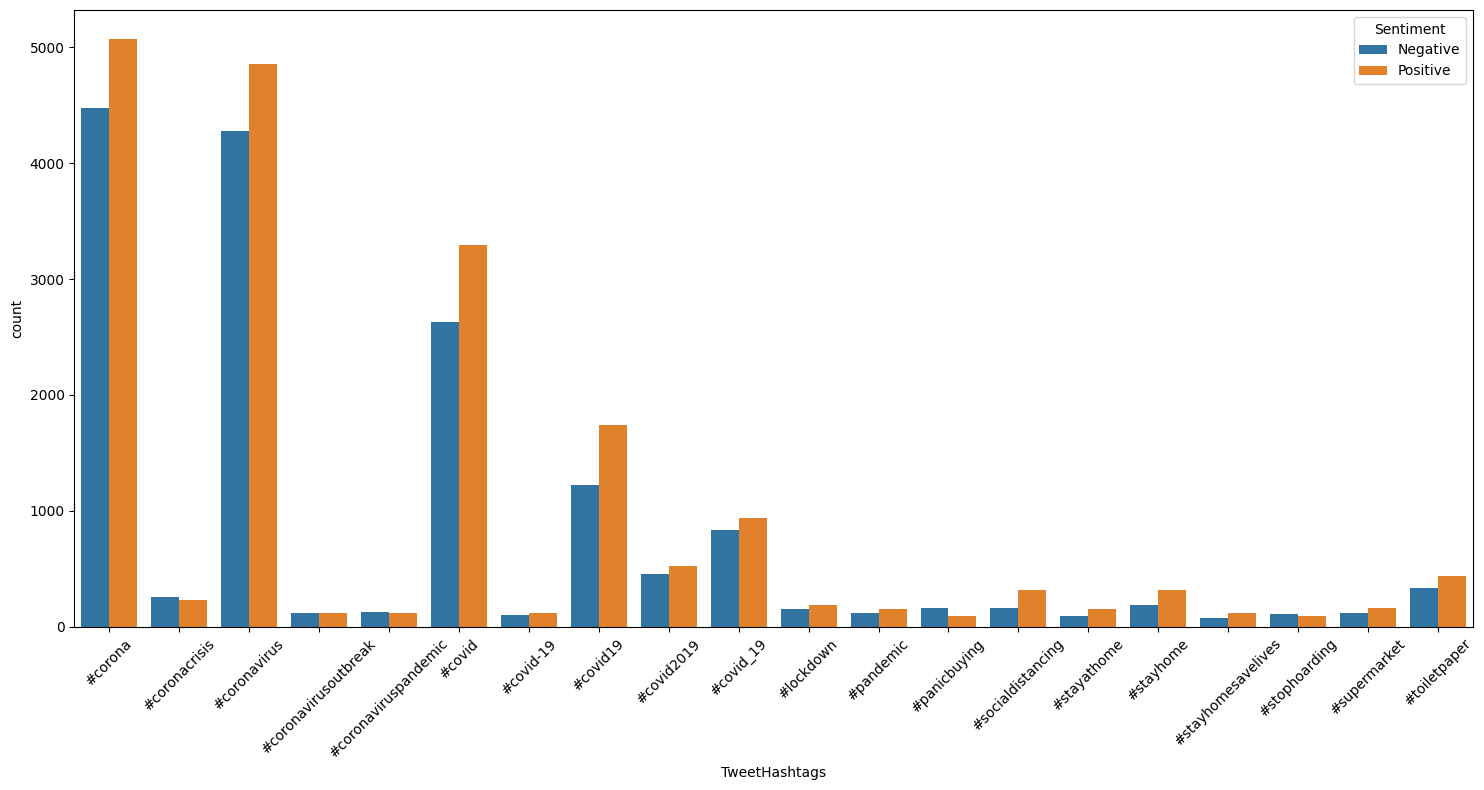

In [62]:
top_20_hashtags = [k for k, v in sorted_TT_tokens if k.startswith('#')][:20]

def get_tweet_hashtags(tweet, hashtags):
    return [hashtag for hashtag in hashtags if hashtag in tweet.lower()]

train_filtered = train.copy()
train_filtered['TweetHashtags'] = train_filtered['OriginalTweet'].apply(lambda x: get_tweet_hashtags(x, top_20_hashtags))
train_filtered = train_filtered[train_filtered['TweetHashtags'].apply(lambda x: len(x) > 0)]


train_filtered_exploded = train_filtered.explode('TweetHashtags')

hashtag_sentiment_individual = train_filtered_exploded.groupby(['TweetHashtags', 'Sentiment']).size().reset_index(name='count')
hashtag_sentiment_individual['Sentiment'] = hashtag_sentiment_individual['Sentiment'].map({0: 'Negative', 1: 'Positive'})


plt.figure(figsize=(15, 8))
sns.barplot(data=hashtag_sentiment_individual, x='TweetHashtags', y='count', hue='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Тоже бесполезная информация
sorted([(k,v) for k, v in tokens.items() if k.startswith('https://t.co')],key = lambda x:x[1],reverse = True)[:20]


[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfâ', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3),
 ('https://t.co/wuieefsnoj', 3),
 ('https://t.co/oi39zsanq8', 3),
 ('https://t.co/rafj2l2ceq', 2),
 ('https://t.co/of8enb5kxp', 2),
 ('https://t.co/ozeniasfeo', 2),
 ('https://t.co/9gjx7znzf4', 2),
 ('https://t.co/i7lk8xuvmr', 2),
 ('https://t.co/skwgk66i8z', 2),
 ('https://t.co/r7sagojsjg', 2)]

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [19]:
def custom_tokenizer(text):
  tokens = []
  tokenizer = TweetTokenizer()

  for token in tokenizer.tokenize(text.lower()):
    if (token not in stopwords.words('english') and token not in punctuation
    and not (len(token) ==1 and ord(token) >= 128) and not token.startswith('https://t.co')):
      tokens.append(token)
  return tokens


## Векторизация

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)
cv.fit(train.OriginalTweet)

print(len(cv.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45300


In [23]:
train.loc[2536]['OriginalTweet'], train.loc[2536]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

In [24]:
X = cv.transform([train.loc[2536]['OriginalTweet']])
vector_array = X.toarray().flatten()
feature_names = cv.get_feature_names_out()

nonzero_tokens = {
    feature_names[i]: vector_array[i]
    for i in np.nonzero(vector_array)[0]
}

nonzero_tokens

{'#coronavirusoutbreak': 1,
 '#covid2019': 1,
 '@skynews': 1,
 'brainless': 1,
 'ffs': 1,
 'food': 1,
 'france': 1,
 'lets': 1,
 'nice': 1,
 'one': 1,
 'panic': 1,
 'ppl': 1,
 'queueing': 1,
 'show': 1}

In [26]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
236,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
4943,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÂre giving supermarkets the optio...,1
420,4219,49171,"Boston, MA",16-03-2020,[THREAD] China's role in wildlife trade should...,1
26712,30511,75463,London,02-04-2020,Coronavirus career pivots: 'I now work in a su...,1
28730,32529,77481,"Moulton, England",05-04-2020,Well done James great front of store before we...,1
...,...,...,...,...,...,...
26809,30608,75560,Unknown,02-04-2020,@dino_melaye I commend your efforts so far in ...,1
29219,33018,77970,Unknown,05-04-2020,Absolutely brilliant idea amp a great use of a...,1
31729,35528,80480,Bay Area,07-04-2020,Afraid of tracking in the #coronavirus? Here a...,1
23112,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1


In [27]:
train.loc[24179].OriginalTweet

'Thank you to the medical professionals, scientists, the honest, dedicated government leaders, the grocery store and other essential business/service workers. . . you are doing a great job! I appreciate this. #coronavirus'

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = custom_tokenizer).fit(train.OriginalTweet)

positive_tweet = tfidf.transform([train.loc[24179]['OriginalTweet']])

vector_array = positive_tweet.toarray().flatten()
feature_names = tfidf.get_feature_names_out()

nonzero_tokens = {
    feature_names[i]: vector_array[i]
    for i in np.nonzero(vector_array)[0]
}
sorted([(k,v) for k,v in nonzero_tokens.items()],key = lambda x: x[1],reverse=True)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('. . .', 0.34544518523867573),
 ('honest', 0.3236514124785788),
 ('scientists', 0.2970751473851067),
 ('dedicated', 0.29108255037048053),
 ('leaders', 0.27649069208274),
 ('professionals', 0.27460645369028786),
 ('appreciate', 0.2648587236650648),
 ('job', 0.21797013982927366),
 ('medical', 0.21244218580799384),
 ('service', 0.2087473568817296),
 ('great', 0.20001438703591998),
 ('government', 0.19471336908481993),
 ('business', 0.19413842733010736),
 ('essential', 0.19199534064774615),
 ('thank', 0.18830735109967958),
 ('workers', 0.15448058022318353),
 ('grocery', 0.11718995670740383),
 ('store', 0.1137114448490038),
 ('#coronavirus', 0.07906921825329927)]

## Обучение первых моделей

In [29]:
X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidf.transform(train.OriginalTweet)
y_train = train.Sentiment

X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidf.transform(test.OriginalTweet)
y_test = test.Sentiment

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg_cv = LogisticRegression().fit(X_train_cv, y_train)
logreg_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)

y_test_pred_cv = logreg_cv.predict(X_test_cv)
y_test_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)


print('train data: ')
print("accuracy cv_vectorizer - ", accuracy_score(logreg_cv.predict(X_train_cv), y_train))
print('accuracy tf-idf vectorizer - ', accuracy_score(logreg_tfidf.predict(X_train_tfidf), y_train))

print('test data: ')
print('accuracy cv vectorizer - ',accuracy_score(test.Sentiment, y_test_pred_cv))
print('accuracy tf-idf vectorizer - ',accuracy_score(test.Sentiment, y_test_pred_tfidf))

train data: 
accuracy cv_vectorizer -  0.9844510892780863
accuracy tf-idf vectorizer -  0.9225117471166169
test data: 
accuracy cv vectorizer -  0.8675503288818018
accuracy tf-idf vectorizer -  0.8527008172214471


In [31]:
from sklearn.metrics import classification_report
print(classification_report(test.Sentiment, y_test_pred_cv))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.88      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



## Стемминг

Для уменьшения словаря можно использовать стемминг.


In [35]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):

  tokens = custom_tokenizer(text)
  stemmer = SnowballStemmer('english')
  tokens = [stemmer.stem(token) for token in tokens]
  return tokens

In [37]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)

X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidf.transform(train.OriginalTweet)

X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidf.transform(test.OriginalTweet)

print(len(cv.vocabulary_))
print(len(tfidf.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36644
36644


In [38]:
logreg_cv = LogisticRegression().fit(X_train_cv,train.Sentiment)
logreg_tfidf = LogisticRegression().fit(X_train_tfidf, train.Sentiment)

y_pred_cv = logreg_cv.predict(X_test_cv)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print('test data : ')
print('accuracy cv vectorizer - ',accuracy_score(test.Sentiment, y_pred_cv))
print('accuracy tf-idf vectorizer - ',accuracy_score(test.Sentiment, y_pred_tfidf))
# как видим применение стемминга особо не повлияло

test data : 
accuracy cv vectorizer -  0.8673510065776361
accuracy tf-idf vectorizer -  0.8566872633047639


## Эксперименты с векторизацией

In [40]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train.OriginalTweet
                            )
X_train_cv = cv_df.transform(train.OriginalTweet)
X_test_cv = cv_df.transform(test.OriginalTweet)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3687


In [41]:
logreg_cv = LogisticRegression().fit(X_train_cv,train.Sentiment)
y_pred_cv = logreg_cv.predict(X_test_cv)
accuracy_score(test.Sentiment, y_pred_cv)

0.8680486346422165

In [42]:
from math import log
from sklearn.preprocessing import StandardScaler
skaler = StandardScaler(with_mean=False).fit(X_train_cv)
X_cv_stem_scaled = skaler.transform(X_train_cv)
logreg_cv = LogisticRegression().fit(X_cv_stem_scaled,train.Sentiment)
y_pred_cv = logreg_cv.predict(skaler.transform(cv_df.transform(test.OriginalTweet)))
accuracy_cv_stem = accuracy_score(test.Sentiment, y_pred_cv)
accuracy_cv_stem

0.8447279250548136

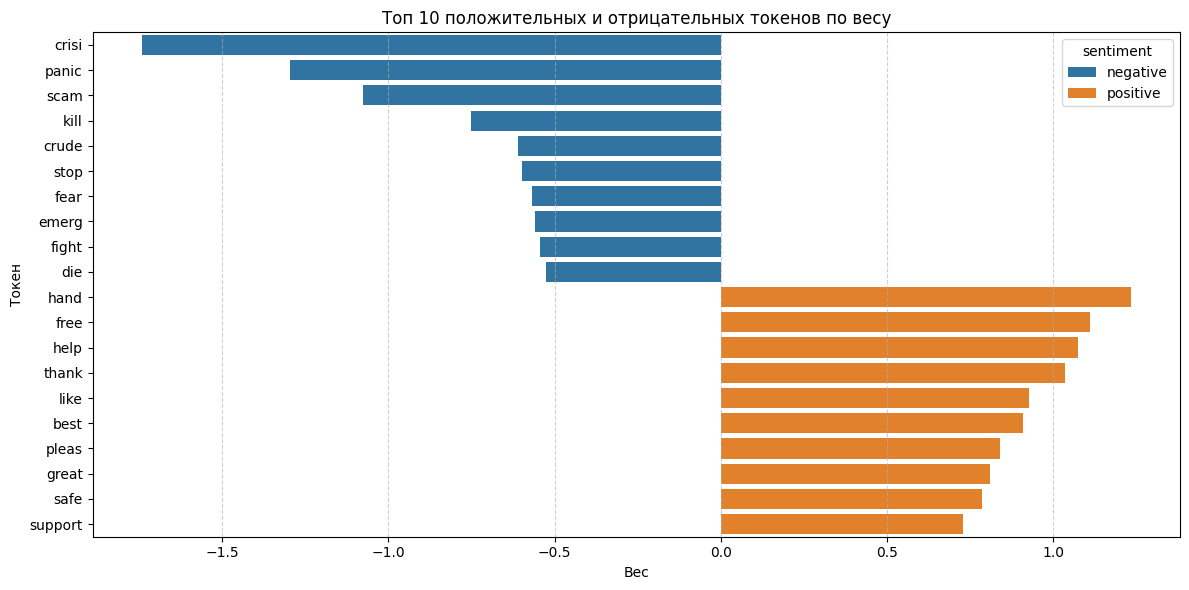

In [64]:
feature_names = cv_df.get_feature_names_out()
coefs = logreg_cv.coef_[0]

# Создаем DataFrame с токенами и их весами
coef_df = pd.DataFrame({
    'token': feature_names,
    'weight': coefs
})

# Наибольшие положительные веса
top_positive = coef_df.sort_values(by='weight', ascending=False).head(10)

# Наибольшие отрицательные веса
top_negative = coef_df.sort_values(by='weight').head(10)


top_tokens = pd.concat([top_negative, top_positive])
top_tokens['sentiment'] = ['negative']*10 + ['positive']*10

plt.figure(figsize=(12, 6))
sns.barplot(data=top_tokens, x='weight', y='token', hue='sentiment', dodge=False)
plt.title('Топ 10 положительных и отрицательных токенов по весу')
plt.xlabel('Вес')
plt.ylabel('Токен')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Остальные признаки

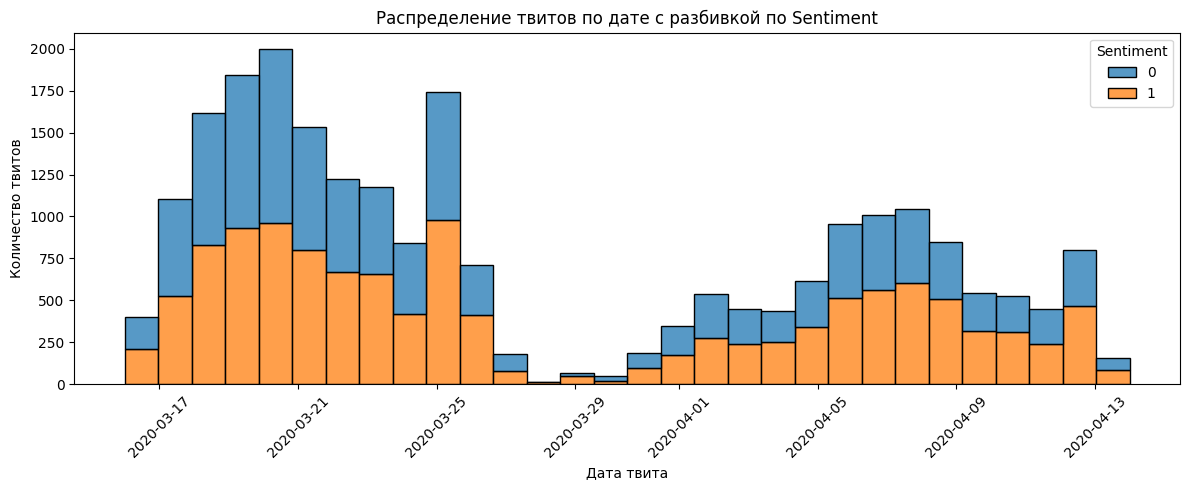

In [44]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'],format="%d-%m-%Y")
plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', multiple='stack', bins=30)
plt.title('Распределение твитов по дате с разбивкой по Sentiment')
plt.xlabel('Дата твита')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#дата твита не влияет на таргет

In [45]:
train.Location.value_counts()

,count
Location,
Unknown,4944
London,301
United States,295
"London, England",274
"New York, NY",223
...,...
Work: Kent and Live: Sussex,1
Somewhere on TradingView,1
"Honolulu, Hawai?i",1


/tmp/ipython-input-109026418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


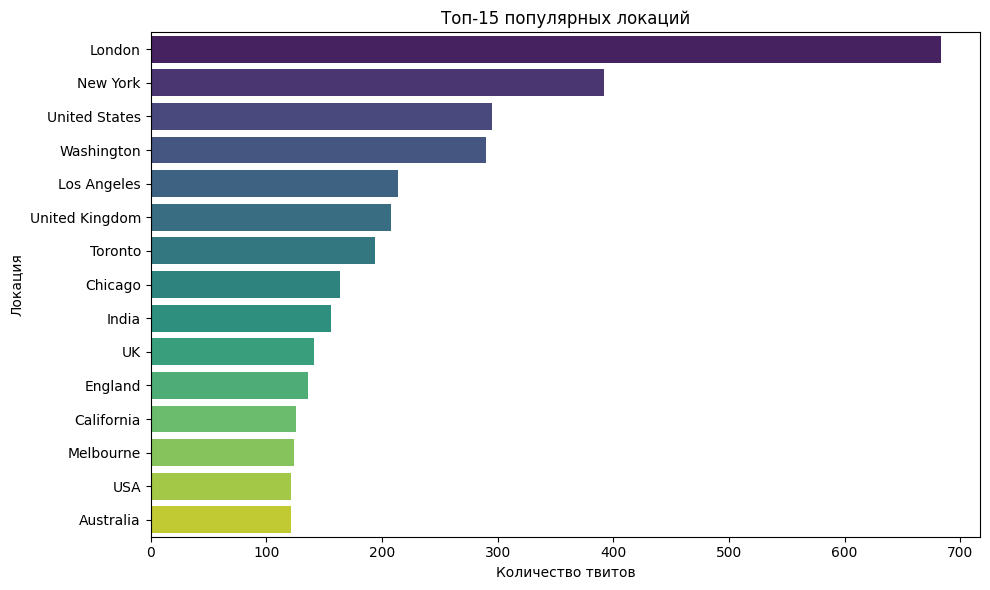

In [65]:
top_locations = train[train.Location !='Unknown'].Location.value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Топ-15 популярных локаций')
plt.xlabel('Количество твитов')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак, который который содержит более общее местоположение.

In [47]:
train['Location'] = train['Location'].str.split(",").str[0]
test['Location'] = test['Location'].str.split(",").str[0]
train.Location.value_counts()

,count
Location,
Unknown,4944
London,683
New York,392
United States,295
Washington,290
...,...
Mississippi & New Orleans,1
Randalstown,1
Fairfield,1


In [48]:
def get_wider_location(location: str) -> str:
    location_to_country = {
      # USA
      'New York': 'United States', 'New York City': 'United States',
      'United States': 'United States', 'Washington': 'United States',
      'Los Angeles': 'United States', 'Chicago': 'United States',
      'California': 'United States', 'USA': 'United States',
      'Boston': 'United States', 'Texas': 'United States',
      'Atlanta': 'United States', 'Houston': 'United States',
      'Austin': 'United States', 'Philadelphia': 'United States',
      'Dallas': 'United States', 'Seattle': 'United States',
      'Florida': 'United States', 'New Jersey': 'United States',
      'San Diego': 'United States', 'Denver': 'United States',
      'Las Vegas': 'United States', 'Michigan': 'United States',
      'Miami': 'United States', 'Brooklyn': 'United States',

      # UK
      'London': 'United Kingdom', 'UK': 'United Kingdom',
      'United Kingdom': 'United Kingdom', 'England': 'United Kingdom',
      'Manchester': 'United Kingdom', 'Scotland': 'United Kingdom',

      # Canada
      'Toronto': 'Canada', 'Vancouver': 'Canada',
      'Ottawa': 'Canada', 'Canada': 'Canada',

      # India
      'India': 'India', 'New Delhi': 'India', 'Mumbai': 'India',

      # Australia
      'Australia': 'Australia', 'Sydney': 'Australia', 'Melbourne': 'Australia',

      # Africa
      'Lagos': 'Nigeria', 'Nigeria': 'Nigeria', 'Nairobi': 'Kenya',
      'South Africa': 'South Africa',

      # Asia
      'Singapore': 'Singapore', 'Dubai': 'United Arab Emirates',

      # Global/Unknown
      'Global': 'Global', 'Worldwide': 'Global', 'Unknown': 'Unknown'
    }
    if location not in location_to_country:
        return location

    return location_to_country[location]

train['WiderLocation'] = train.Location.apply(get_wider_location)
test['WiderLocation'] = test.Location.apply(get_wider_location)
train.WiderLocation.value_counts().shape

(6359,)

/tmp/ipython-input-1009422867.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


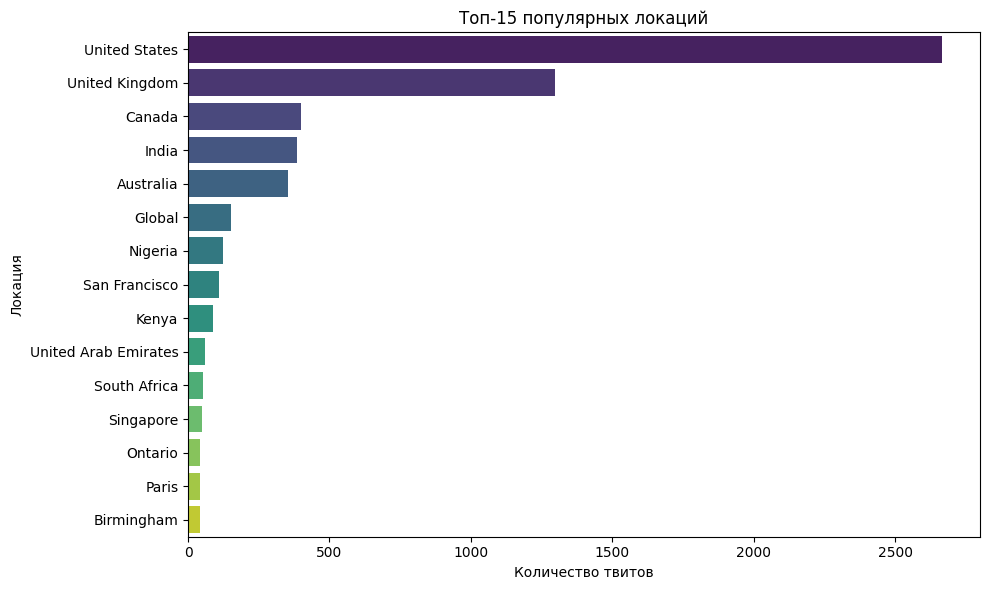

In [49]:
top_locations = train[train.Location !='Unknown'].WiderLocation.value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Топ-15 популярных локаций')
plt.xlabel('Количество твитов')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Закодируем признак WiderLocation.


In [51]:
from sklearn.preprocessing import OneHotEncoder
import scipy

value_counts = train.WiderLocation.value_counts()[train.WiderLocation.value_counts()>1]


valid_locations = value_counts.index.tolist()

encoder = OneHotEncoder(
    categories=[valid_locations],
    handle_unknown='ignore'
)

encoder.fit(train[['WiderLocation']])


X_train_cv_withloc = scipy.sparse.hstack([X_train_cv, encoder.transform(train[['WiderLocation']])])

In [52]:
X_test_cv_withloc = scipy.sparse.hstack([
    X_test_cv,
    encoder.transform(test[['WiderLocation']])])

logreg_withloc = LogisticRegression().fit(X_train_cv_withloc,train.Sentiment)
y_pred_withloc = logreg_withloc.predict(X_test_cv_withloc)
accuracy_score(y_pred_withloc,test.Sentiment)

0.8677496511859677

качество не изменилось

In [54]:
from xgboost import XGBClassifier
# param = {'n_estimators'}
accuracy_mass = {}
for i in range(100,2000,100):
  xgmodel = XGBClassifier(n_estimators = i).fit(X_train_cv_withloc,train.Sentiment)
  y_pred_xg = xgmodel.predict(X_test_cv_withloc)
  accuracy_mass[i] = accuracy_score(y_pred_xg,test.Sentiment)
accuracy_mass

{100: 0.8206099262507475,
 200: 0.8497109826589595,
 300: 0.8576838748255929,
 400: 0.8645604943193144,
 500: 0.8670520231213873,
 600: 0.8679489734901336,
 700: 0.8696432130755432,
 800: 0.8696432130755432,
 900: 0.8689455850109628,
 1000: 0.8709388080526211,
 1100: 0.8690452461630457,
 1200: 0.8684472792505481,
 1300: 0.8671516842734702,
 1400: 0.8660554116005581,
 1500: 0.8656567669922264,
 1600: 0.864859477775563,
 1700: 0.8650588000797289,
 1800: 0.8644608331672314,
 1900: 0.8635638827984852}

In [55]:
xgmodel = XGBClassifier(n_estimators = 2000,max_depth = 4,learning_rate = 0.18,n_jobs = -1).fit(X_train_cv_withloc,train.Sentiment)
y_pred_xg = xgmodel.predict(X_test_cv_withloc)
accuracy_score(y_pred_xg,test.Sentiment)

0.873529998006777

In [56]:
from gensim.models import Word2Vec

temp = train.OriginalTweet.apply(custom_stem_tokenizer)

model_w2v = Word2Vec(sentences=temp,vector_size=100, window=5, min_count=2, workers=4)

def tweet_vector(tokens):
    vectors = [model_w2v.wv[word] for word in tokens if word in model_w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

temp = temp.apply(tweet_vector)

X_train = np.vstack(temp.values)
y_train = train.Sentiment.astype(int)
X_test = np.vstack(test.OriginalTweet.apply(custom_stem_tokenizer).apply(tweet_vector).values)

clf = LogisticRegression().fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_pred,test.Sentiment)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6847717759617301